In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math
from typing import Optional, List
import copy
import numpy as np
from torchvision import datasets, transforms, models

import torch
from torch import nn, Tensor
import torchvision
from torchvision.models import resnet50, resnet101
import torchvision.transforms as T
import torch.nn.functional as F
torch.set_grad_enabled(False);

import pdb

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor, Generator_loss
from models.unet import UNet

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)

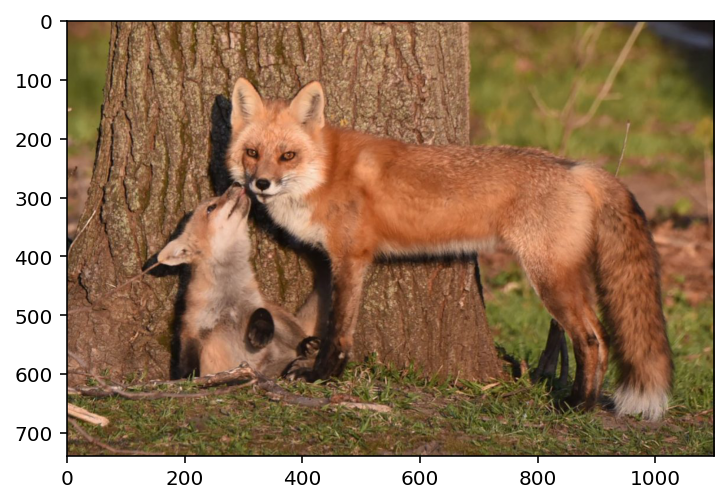

In [5]:
plt.plot()
plt.imshow(im)

In [6]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

In [8]:
unet = UNet(3,3).to(device)
backbone = Backbone().to(device)
encoder = EncoderModule().to(device)
model = Joiner(backbone, encoder, hidden_dim=512, image_h=H, image_w=W)

In [9]:
model = model.to(device)

In [11]:
#for param in model.parameters():
#  param.requires_grad = True

In [12]:
#for param in unet.parameters():
#  print(param.requires_grad)# = True

In [13]:
img = transform2(im).unsqueeze(0).to(device)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [14]:
noise = unet(img)

In [15]:
def model_test(im, model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform2(im).unsqueeze(0).to(device)

    # propagate through the model
    #output = model(img)
    output, att_map, sattn, f_map, pos, pattn = model(img)
    return output, att_map, sattn, f_map, pos, pattn

In [16]:
outputs, att, sattn, f_map, pos, pattn = model_test(im,model)

In [17]:
print("Output shape:", outputs.shape)
print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
print("Encoder output shape:", att.shape)
print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Feature Map shape: torch.Size([1, 512, 12, 12])
Attention Maps shape: torch.Size([1, 12, 12, 12, 12])
Encoder output shape: torch.Size([1, 512, 12, 12])
Positional Encoding shape: torch.Size([1, 512, 12, 12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


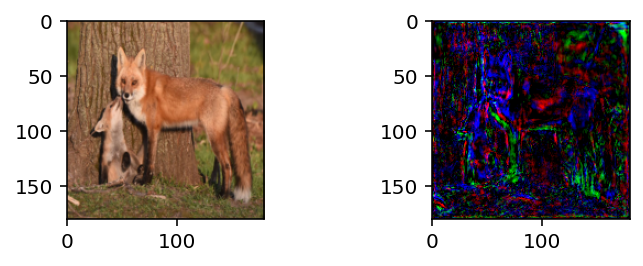

In [18]:
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noise[0].cpu().permute(1, 2, 0))

In [19]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

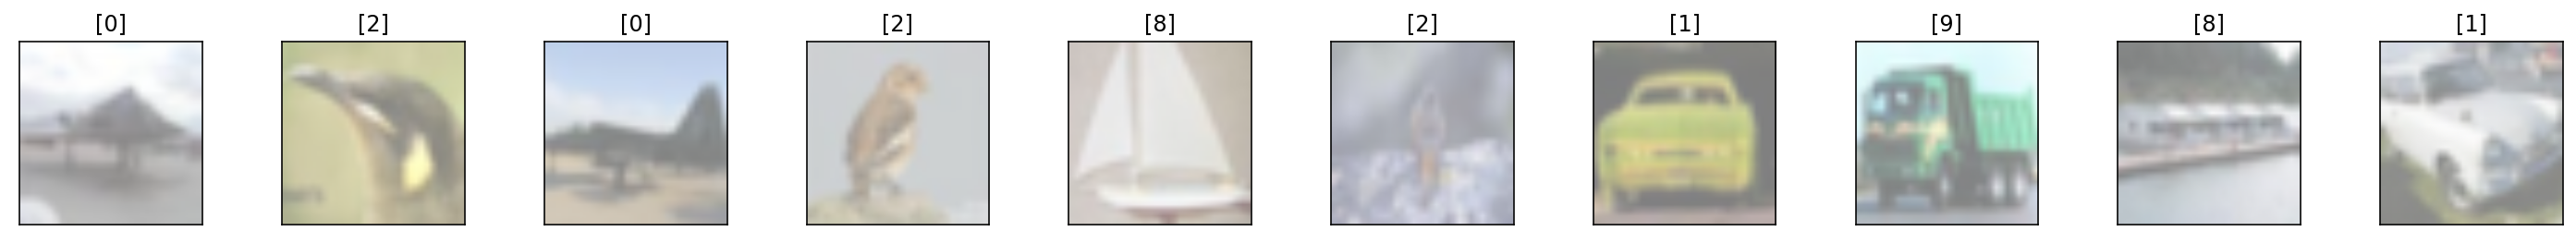

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [20]:
#criterion = Generator_loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(unet.parameters(), lr = 0.0001)

In [ ]:
epochs = 2
running_loss_history = [] # training loss - to generate a plot
#running_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
#val_running_corrects_history = [] # validation accuracy

for e in range(epochs):
  
    running_loss = 0.0
    #running_corrects = 0.0
    val_running_loss = 0.0
    #val_running_corrects = 0.0

    for inputs, labels in training_loader:
    #TRAINING
        inputs = inputs.to(device) # allow gpu use
        #inputs.requires_grad = True
        labels = labels.to(device) # allow gpu use
        noised_input = unet(inputs)
        #noised_input.requires_grad = True
        #outputs, att, sattn, f_map, pos, pattn = model(noised_input) #gives the output of the last layer
        #loss = criterion(pattn,noised_input,inputs) # comparing outputs and labels using the criteria
        loss = criterion(noised_input,inputs)
        loss.requires_grad = True
        
        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
            
        #pdb.set_trace()
        
        optimizer.step() #optimize weights 
        
        for name, param in unet.named_parameters():
            if param.grad is not None:
                print(name, param.grad.sum())
            else:
                param.requires_grad_()
                print(name, param.grad)

        #_, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        running_loss += loss # the sum of the loss of all itens
        #running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs

    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_noised_input = unet(val_inputs)
                #val_outputs, att, sattn, f_map, pos, val_pattn = model(val_noised_input) #passes the image through the network and get the output
                #val_loss = criterion(val_pattn,val_noised_input,val_inputs) #compare output and labels to get the loss 
                val_loss = criterion(val_noised_input,val_inputs)
                
                #_, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss #same as for training
                #val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training

    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_dataset) # the sum of the loss of all itens divided by the number of itens
    #epoch_acc = running_corrects.float()/ len(training_dataset) # the sum of correct predictions divided by the number of itens
    running_loss_history.append(epoch_loss) #append to respective list
    #running_corrects_history.append(epoch_acc) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_dataset)
    #val_epoch_acc = val_running_corrects.float()/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    #val_running_corrects_history.append(val_epoch_acc) #append to respective list
    print('epoch :', (e+1))
    print('training loss: {:.4f}'.format(epoch_loss))
    print('validation loss: {:.4f}'.format(val_epoch_loss))

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

up4.conv.double_conv.3.bias None
up4.conv.double_conv.4.weight None
up4.conv.double_conv.4.bias None
outc.conv.weight None
outc.conv.bias None
inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.doubl

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

outc.conv.bias None
inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpoo

up3.conv.double_conv.1.bias None
up3.conv.double_conv.3.weight None
up3.conv.double_conv.3.bias None
up3.conv.double_conv.4.weight None
up3.conv.double_conv.4.bias None
up4.conv.double_conv.0.weight None
up4.conv.double_conv.0.bias None
up4.conv.double_conv.1.weight None
up4.conv.double_conv.1.bias None
up4.conv.double_conv.3.weight None
up4.conv.double_conv.3.bias None
up4.conv.double_conv.4.weight None
up4.conv.double_conv.4.bias None
outc.conv.weight None
outc.conv.bias None
inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.max

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

up2.conv.double_conv.0.bias None
up2.conv.double_conv.1.weight None
up2.conv.double_conv.1.bias None
up2.conv.double_conv.3.weight None
up2.conv.double_conv.3.bias None
up2.conv.double_conv.4.weight None
up2.conv.double_conv.4.bias None
up3.conv.double_conv.0.weight None
up3.conv.double_conv.0.bias None
up3.conv.double_conv.1.weight None
up3.conv.double_conv.1.bias None
up3.conv.double_conv.3.weight None
up3.conv.double_conv.3.bias None
up3.conv.double_conv.4.weight None
up3.conv.double_conv.4.bias None
up4.conv.double_conv.0.weight None
up4.conv.double_conv.0.bias None
up4.conv.double_conv.1.weight None
up4.conv.double_conv.1.bias None
up4.conv.double_conv.3.weight None
up4.conv.double_conv.3.bias None
up4.conv.double_conv.4.weight None
up4.conv.double_conv.4.bias None
outc.conv.weight None
outc.conv.bias None
inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

inc.double_conv.0.weight None
inc.double_conv.0.bias None
inc.double_conv.1.weight None
inc.double_conv.1.bias None
inc.double_conv.3.weight None
inc.double_conv.3.bias None
inc.double_conv.4.weight None
inc.double_conv.4.bias None
down1.maxpool_conv.1.double_conv.0.weight None
down1.maxpool_conv.1.double_conv.0.bias None
down1.maxpool_conv.1.double_conv.1.weight None
down1.maxpool_conv.1.double_conv.1.bias None
down1.maxpool_conv.1.double_conv.3.weight None
down1.maxpool_conv.1.double_conv.3.bias None
down1.maxpool_conv.1.double_conv.4.weight None
down1.maxpool_conv.1.double_conv.4.bias None
down2.maxpool_conv.1.double_conv.0.weight None
down2.maxpool_conv.1.double_conv.0.bias None
down2.maxpool_conv.1.double_conv.1.weight None
down2.maxpool_conv.1.double_conv.1.bias None
down2.maxpool_conv.1.double_conv.3.weight None
down2.maxpool_conv.1.double_conv.3.bias None
down2.maxpool_conv.1.double_conv.4.weight None
down2.maxpool_conv.1.double_conv.4.bias None
down3.maxpool_conv.1.double_conv

In [ ]:
noise2 = unet(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


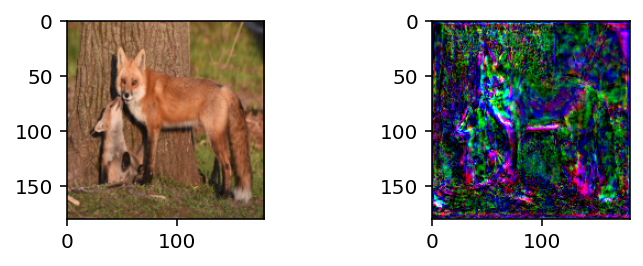

In [28]:
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noise[0].cpu().permute(1, 2, 0))
#plt.subplot(223)
#plt.imshow(noise2[0].cpu().permute(1, 2, 0))

In [ ]:
plt.subplot(221)
plt.imshow(inputs[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noised_input[0].cpu().permute(1, 2, 0))

In [22]:
#for param in unet.parameters():
    #print(param.grad.data.sum())
#    print(param.grad)

In [32]:
x = img
target = img
outputs = unet(x)
outputs.requires_grad = True
outputs.retain_grad()
outputs.requires_grad

True

In [33]:
loss = criterion(outputs, target)
loss.requires_grad = True

In [34]:
loss.backward()
print(loss.grad)

tensor(1., device='cuda:0')


In [35]:
unet = unet.requires_grad_()

In [36]:
optimizer.step()

In [37]:
for name, param in unet.named_parameters():
    if param.grad is not None:
        print(name, param.grad.sum())
    else:
        param.requires_grad_()
        param.retain_grad()
        print(name, param.requires_grad, param.grad)

inc.double_conv.0.weight True None
inc.double_conv.0.bias True None
inc.double_conv.1.weight True None
inc.double_conv.1.bias True None
inc.double_conv.3.weight True None
inc.double_conv.3.bias True None
inc.double_conv.4.weight True None
inc.double_conv.4.bias True None
down1.maxpool_conv.1.double_conv.0.weight True None
down1.maxpool_conv.1.double_conv.0.bias True None
down1.maxpool_conv.1.double_conv.1.weight True None
down1.maxpool_conv.1.double_conv.1.bias True None
down1.maxpool_conv.1.double_conv.3.weight True None
down1.maxpool_conv.1.double_conv.3.bias True None
down1.maxpool_conv.1.double_conv.4.weight True None
down1.maxpool_conv.1.double_conv.4.bias True None
down2.maxpool_conv.1.double_conv.0.weight True None
down2.maxpool_conv.1.double_conv.0.bias True None
down2.maxpool_conv.1.double_conv.1.weight True None
down2.maxpool_conv.1.double_conv.1.bias True None
down2.maxpool_conv.1.double_conv.3.weight True None
down2.maxpool_conv.1.double_conv.3.bias True None
down2.maxpool_

In [38]:
optimizer.step()